# Cleverly Challenge - Part 2

This notebook is predominately about creating a suitable dataset, including resampling and preprocessing the text

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import itertools
import datetime
import re

In [3]:
from numba import jit, cuda 
import numpy as np 
# to measure exec time 
from timeit import default_timer as timer    

In [4]:
import fasttext
import string
from spellchecker import SpellChecker

In [5]:
import emoji
from tqdm import tqdm, tqdm_notebook, trange


In [38]:
from imblearn.under_sampling import RandomUnderSampler

Get the dataset that has reviews without any total votes filtered out, ie. only contain ones with helpful votes

In [3]:
df_review_helpful = pd.read_csv("review_helpful.csv")

In [4]:
df_review_helpful.head()

,Unnamed: 0,reviewTime,num_helpful,total_votes,helpful_score,overall,word_count,summary,reviewText,reviewerID,reviewerName,year,month,day,dow,reviewYearMonth,word_count_binned,word_count_binned2
0,440,2014-07-03,1.0,1.0,1.00,5,8,Five Stars,I love these. So cute and just right,AZH1SOHEON09U,Sandy Elizabeth Donis,2014,7,3,3,2014-07,20,"(-2.881, 130.367]"
1,2309,2007-05-13,1.0,1.0,1.00,5,7,Levi's 501 Original Fit Button Fly Jeans (Purc...,It is perfect. It fits me great.,A2DQPW08PVTYUK,Pedro A. Salcedo Quijano,2007,5,13,6,2007-05,20,"(-2.881, 130.367]"
2,8265,2007-06-15,1.0,4.0,0.25,5,8,Love it,Invicta makes a great product for the money.,A3INN916E4VION,S. Kosloske,2007,6,15,4,2007-06,20,"(-2.881, 130.367]"
3,11398,2014-07-01,0.0,1.0,0.00,5,1,Five Stars,nice,A3ACCVELQ149WV,Rosie,2014,7,1,1,2014-07,20,"(-2.881, 130.367]"
4,16987,2014-07-09,0.0,1.0,0.00,5,3,Five Stars,love it !,A2HZMU26RB3CZ5,Shalva Julukhadze,2014,7,9,2,2014-07,20,"(-2.881, 130.367]"


Combine "summary" field with "reviewText" field

In [5]:
df_review_helpful["combinedText"] =  df_review_helpful["summary"] + " " + df_review_helpful["reviewText"]

In [6]:
# change word count to use combined text
df_review_helpful['word_count'] = df_review_helpful['combinedText'].str.split().str.len()

In [7]:
df_review_helpful.shape, df_review_helpful[df_review_helpful.total_votes >2].shape

((86996, 19), (30990, 19))

In [8]:
df_review_helpful.describe()

,Unnamed: 0,num_helpful,total_votes,helpful_score,overall,word_count,year,month,day,dow,word_count_binned
count,86996.000000,86996.000000,86996.000000,86996.000000,86996.000000,86996.000000,86996.000000,86996.000000,86996.000000,86996.000000,86996.000000
mean,142375.953067,3.662605,4.298014,0.779994,4.059072,83.372833,2012.668295,6.305083,15.668663,2.811624,94.341579
std,80044.440845,11.347865,12.072183,0.346836,1.253076,85.422100,1.220573,3.709981,8.723096,1.922365,123.787861
min,9.000000,0.000000,1.000000,0.000000,1.000000,2.000000,2003.000000,1.000000,1.000000,0.000000,20.000000
25%,73845.250000,1.000000,1.000000,0.666667,3.000000,35.000000,2012.000000,3.000000,8.000000,1.000000,40.000000
50%,142855.500000,1.000000,2.000000,1.000000,5.000000,58.000000,2013.000000,6.000000,16.000000,3.000000,60.000000
75%,211863.500000,3.000000,4.000000,1.000000,5.000000,100.000000,2013.000000,10.000000,23.000000,4.000000,100.000000
max,278676.000000,1200.000000,1267.000000,1.000000,5.000000,3898.000000,2014.000000,12.000000,31.000000,6.000000,4000.000000


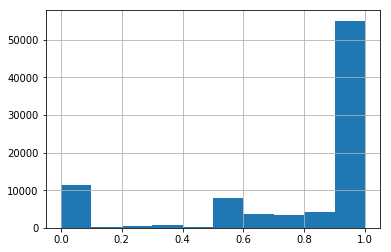

In [9]:
df_review_helpful.helpful_score.hist()

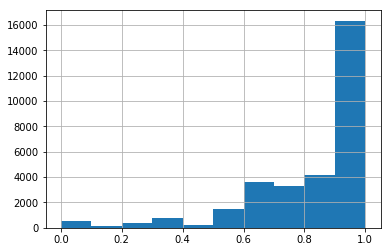

In [10]:
df_review_helpful[df_review_helpful.total_votes >2].helpful_score.hist()

In [11]:
len(df_review_helpful[df_review_helpful.helpful_score < 0.5]), len(df_review_helpful[df_review_helpful.helpful_score == 0.5]), len(df_review_helpful[df_review_helpful.helpful_score > 0.5])

(12774, 7274, 66948)

In [12]:
len(df_review_helpful[(df_review_helpful.total_votes >=2) & (df_review_helpful.helpful_score < 0.5)]), len(df_review_helpful[(df_review_helpful.total_votes >= 2) & (df_review_helpful.helpful_score == 0.5)]), len(df_review_helpful[(df_review_helpful.total_votes >= 2) & (df_review_helpful.helpful_score > 0.5)])

(3053, 7274, 37224)

Text(0.5, 1.0, 'Observations with total helpful votes >= 2')

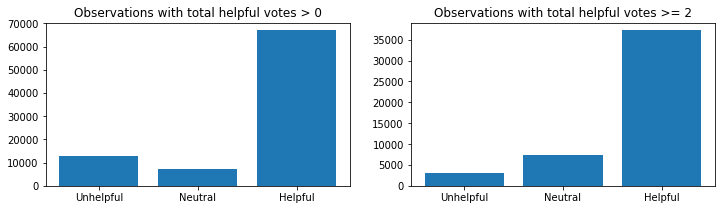

In [13]:
fig = plt.figure(figsize=(12, 3))
ax = plt.subplot(1,2, 1)   
#ax = fig.add_axes([0,0,1,1])
type = ['Unhelpful', 'Neutral', "Helpful"]
counts = [len(df_review_helpful[df_review_helpful.helpful_score < 0.5]), len(df_review_helpful[df_review_helpful.helpful_score == 0.5]), len(df_review_helpful[df_review_helpful.helpful_score > 0.5])]
ax.bar(type,counts)
ax.set_title('Observations with total helpful votes > 0')

ax2 = plt.subplot(1,2, 2)   
type = ['Unhelpful', 'Neutral', "Helpful"]
counts2 = [len(df_review_helpful[(df_review_helpful.total_votes >=2) & (df_review_helpful.helpful_score < 0.5)]), len(df_review_helpful[(df_review_helpful.total_votes >= 2) & (df_review_helpful.helpful_score == 0.5)]), len(df_review_helpful[(df_review_helpful.total_votes >= 2) & (df_review_helpful.helpful_score > 0.5)])]
ax2.bar(type,counts2)
ax2.set_title('Observations with total helpful votes >= 2')

__comment:__ There are significantly more helpful votes (helpful score > 0.5) than unhelpful votes (helpful score < 0.5). The difference is even more pronounced if we look at reviews with two or more total votes

In [14]:
len(df_review_helpful[(df_review_helpful.helpful_score < 0.5) & (df_review_helpful.word_count <= 200)]), len(df_review_helpful[(df_review_helpful.helpful_score == 0.5) & (df_review_helpful.word_count <= 200)]), len(df_review_helpful[(df_review_helpful.helpful_score > 0.5) & (df_review_helpful.word_count <= 200)])

(12368, 6870, 61962)

In [15]:
len(df_review_helpful[(df_review_helpful.total_votes >=2) & (df_review_helpful.helpful_score < 0.5) & (df_review_helpful.word_count <= 200)]), len(df_review_helpful[(df_review_helpful.total_votes >= 2) & (df_review_helpful.helpful_score == 0.5) & (df_review_helpful.word_count <= 200)]), len(df_review_helpful[(df_review_helpful.total_votes >= 2) & (df_review_helpful.helpful_score > 0.5) & (df_review_helpful.word_count <= 200)])

(2893, 6870, 33349)

__comment:__ let's create a filtered dataset containing only unhelpful and helpful votes, using 0.5 as a threshold, with a maximum word count of 200 and having at least one vote

In [17]:
df_review_filtered = df_review_helpful[(df_review_helpful.word_count <= 200) & (df_review_helpful.helpful_score != 0.5)]

df_review_filtered["target"] = df_review_filtered["helpful_score"].apply(lambda x: 1 if x > 0.5 else 0)

df_review_filtered.target.value_counts()

C:\Users\Susan\Anaconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1    61962
0    12368
Name: target, dtype: int64

### Undersample the Majority class (Helpful votes)

In [19]:
rus = RandomUnderSampler(random_state=0)

In [20]:
df_review_filtered.columns

Index(['Unnamed: 0', 'reviewTime', 'num_helpful', 'total_votes',
       'helpful_score', 'overall', 'word_count', 'summary', 'reviewText',
       'reviewerID', 'reviewerName', 'year', 'month', 'day', 'dow',
       'reviewYearMonth', 'word_count_binned', 'word_count_binned2',
       'combinedText', 'target'],
      dtype='object')

In [21]:
X = df_review_filtered.drop(columns=['Unnamed: 0', 'num_helpful', 'total_votes',
       'helpful_score', "target"])

In [22]:
y = df_review_filtered["target"]

In [23]:
X.head()

,reviewTime,overall,word_count,summary,reviewText,reviewerID,reviewerName,year,month,day,dow,reviewYearMonth,word_count_binned,word_count_binned2,combinedText
0,2014-07-03,5,10,Five Stars,I love these. So cute and just right,AZH1SOHEON09U,Sandy Elizabeth Donis,2014,7,3,3,2014-07,20,"(-2.881, 130.367]",Five Stars I love these. So cute and just right
1,2007-05-13,5,17,Levi's 501 Original Fit Button Fly Jeans (Purc...,It is perfect. It fits me great.,A2DQPW08PVTYUK,Pedro A. Salcedo Quijano,2007,5,13,6,2007-05,20,"(-2.881, 130.367]",Levi's 501 Original Fit Button Fly Jeans (Purc...
2,2007-06-15,5,10,Love it,Invicta makes a great product for the money.,A3INN916E4VION,S. Kosloske,2007,6,15,4,2007-06,20,"(-2.881, 130.367]",Love it Invicta makes a great product for the ...
3,2014-07-01,5,3,Five Stars,nice,A3ACCVELQ149WV,Rosie,2014,7,1,1,2014-07,20,"(-2.881, 130.367]",Five Stars nice
4,2014-07-09,5,5,Five Stars,love it !,A2HZMU26RB3CZ5,Shalva Julukhadze,2014,7,9,2,2014-07,20,"(-2.881, 130.367]",Five Stars love it !


In [24]:
y.head()

0    1
1    1
2    0
3    0
4    0
Name: target, dtype: int64

In [25]:
X_resampled, y_resampled = rus.fit_resample(X, y)

In [26]:
from collections import Counter
print('Resampled dataset shape %s' % Counter(y_resampled))

Resampled dataset shape Counter({0: 12368, 1: 12368})


In [27]:
X_resampled.shape

(24736, 15)

## Preprocess Text

In [29]:
 def remove_punctuation(x):
    #pattern = r'[^a-zA-z0-9\s]'
    #pattern = r'[^a-zA-z\s]'
    #text = re.sub(pattern, '', x)
    return x.translate(str.maketrans('', '', string.punctuation))
    #return x

def replace_numbers(x):
    if re.search(r'\d', x):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
        x = re.sub('[0-9]{1}', '#', x)
    return x

spell = SpellChecker()

def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

#@jit(target ="cuda") 
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

#@jit(target ="cuda") 
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = _get_contractions(contraction_dict)

#@jit(target ="cuda") 
def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

In [34]:
replace_contractions("this's a text with contraction")

'this is a text with contraction'

Combine "summary" with "reviewText"

In [35]:
X_resampled["combinedText"] =  X_resampled["summary"] + " " + X_resampled["reviewText"]

In [36]:
X_resampled.head()

,reviewTime,overall,word_count,summary,reviewText,reviewerID,reviewerName,year,month,day,dow,reviewYearMonth,word_count_binned,word_count_binned2,combinedText
0,2007-06-15,5,10,Love it,Invicta makes a great product for the money.,A3INN916E4VION,S. Kosloske,2007,6,15,4,2007-06,20,"(-2.881, 130.367]",Love it Invicta makes a great product for the ...
1,2014-07-01,5,3,Five Stars,nice,A3ACCVELQ149WV,Rosie,2014,7,1,1,2014-07,20,"(-2.881, 130.367]",Five Stars nice
2,2014-07-09,5,5,Five Stars,love it !,A2HZMU26RB3CZ5,Shalva Julukhadze,2014,7,9,2,2014-07,20,"(-2.881, 130.367]",Five Stars love it !
3,2014-07-08,5,3,Perfect,Very comfy.,A2C6NK705NIWKV,P R,2014,7,8,1,2014-07,20,"(-2.881, 130.367]",Perfect Very comfy.
4,2014-07-06,4,4,Four Stars,good belt,A1Y5MCG52TBL1I,OSCAR,2014,7,6,6,2014-07,20,"(-2.881, 130.367]",Four Stars good belt


In [38]:
tqdm.pandas(desc='Progress')

In [39]:
#@jit(target ="cuda") 
def preprocess_text(text):
    #print("p")
    #text = emoji.demojize(text)
    text = replace_numbers(text)
    text = replace_contractions(text)
    text = remove_punctuation(text)    
    text = correct_spellings(text).lower()
    return text

### Save Preprocessed Results to File

In [56]:
def preproc_blocks(df_1, start_i:int, end_i:int, timer_flag=True, save=True, filename="df_preprocessed1.pkl"):
    print(start_i, end_i)
    start = timer() 
    if timer_flag:
        start = timer() 
    df_1["processedText"].iloc[start_i:end_i] = df_1["combinedText"].iloc[start_i:end_i].progress_apply(lambda x: preprocess_text(x))
    if timer_flag:
        print("without GPU:", timer()-start)
    if save:
        df_1.iloc[start_i:end_i].to_pickle(filename) 
    return df_1

In [ ]:
final_len = len(X_resampled) 
step = 1000

start_index = 0
i=0
while start_index < final_len:
    if start_index + step < final_len:
        X_resampled = preproc_blocks(X_resampled, start_index, start_index + step, filename="df_preprocessed_"+str(start_index)+".pkl")
        start_index += step
    else:
        X_resampled = preproc_blocks(X_resampled, start_index, final_len,filename="df_preprocessed_"+str(start_index)+".pkl")
        break


0 1000


Progress: 100%|████████████████████████████████████████████████████████████████████| 1000/1000 [11:23<00:00,  1.46it/s]
C:\Users\Susan\Anaconda3\envs\thesis\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


without GPU: 683.7340084000001
1000 2000


Progress:  73%|██████████████████████████████████████████████████▍                  | 731/1000 [08:53<12:37,  2.82s/it]

In [68]:
X_resampled.processedText.head(10)

0    love it invicta makes a great product for the ...
1                                      five stars nice
2                                   five stars love it
3                                   perfect very comfy
4                                 four stars good belt
5    organizer would considerlikeneeded to be bigge...
6                               five stars perfect fit
7    not really great quality color not really grea...
8               a waste of good money a waste of money
9    great excelentedggfddffrgrgththrththrgthrergnf...
Name: processedText, dtype: object

In [76]:
y_resampled.value_counts()

1    12368
0    12368
Name: target, dtype: int64

In [79]:
X_resampled.to_pickle("df_resampled.pkl") 

In [77]:
y_resampled.to_pickle("target_resampled.pkl") 

In [11]:
X_resampled = pd.read_pickle("df_resampled.pkl") 

In [10]:
y_resampled = pd.read_pickle("target_resampled.pkl") 

In [12]:
X_resampled.shape, y_resampled.shape

((24736, 16), (24736,))

In [19]:
df_combined = X_resampled.merge(y_resampled.to_frame(), left_index=True, right_index=True)

In [31]:
df_combined['reviewTime']= pd.to_datetime(df_combined['reviewTime']) 

In [32]:
df_combined.sort_values("reviewTime").head(10)

,reviewTime,overall,word_count,summary,reviewText,reviewerID,reviewerName,year,month,day,dow,reviewYearMonth,word_count_binned,word_count_binned2,combinedText,processedText,target
14334,2003-03-29,5,52,This bra is the most comfortable,This bra is the most comfortable bra I have ev...,A1X2LENOF84LCQ,"D ""D""",2003,3,29,5,2003-03,60,"(-2.881, 130.367]",This bra is the most comfortable This bra is t...,this bra is the most comfortable this bra is t...,1
16971,2004-07-17,5,164,Absolutely My Favorite!,I just love this bra. I was first introduced ...,A1Z54EM24Y40LL,csm,2004,7,17,5,2004-07,180,"(130.367, 259.733]",Absolutely My Favorite! I just love this bra. ...,absolutely my favorite i just love this bra i ...,1
16626,2004-09-29,5,48,Agree with Momof2,"I purchased these for a teenage cousin, and th...",AB2YZA2HLY75H,Reb,2004,9,29,2,2004-09,60,"(-2.881, 130.367]",Agree with Momof2 I purchased these for a teen...,agree with momof i purchased these for a teena...,1
19830,2004-12-08,5,60,Terrific value for gold earrings,"These earrings just arrived, and for $10 (Frid...",AAPPWNP9FWVWS,"Kathlyn Storey ""Kathlyn A Storey""",2004,12,8,2,2004-12,60,"(-2.881, 130.367]",Terrific value for gold earrings These earring...,terrific value for gold earrings these earring...,1
14393,2005-03-02,4,103,Perfect watch for everyday,"Extremely reliable, easy to read, looks like t...",ADS6Y2663M0W0,Little Mom,2005,3,2,2,2005-03,100,"(-2.881, 130.367]","Perfect watch for everyday Extremely reliable,...",perfect watch for everyday extremely reliable ...,1
22834,2005-09-13,5,91,These are beautiful earrings!,I ordered these earrings and received tons of ...,A11WAEQIABD2FR,Micki Collar,2005,9,13,1,2005-09,100,"(-2.881, 130.367]",These are beautiful earrings! I ordered these ...,these are beautiful earrings i ordered these e...,1
937,2005-09-21,5,37,Quick Service,I ordered at 4:45pm PST and they were able to ...,A36CILYDHT5XOS,"Watch Fan ""Jack""",2005,9,21,2,2005-09,40,"(-2.881, 130.367]",Quick Service I ordered at 4:45pm PST and they...,quick service i ordered at pm pst and they wer...,0
804,2005-12-17,1,127,CHEAP-O WATCH. GOOD FOR KIDS.,"Well, upon getting this watch in the mail, I w...",A32S2SF5U73GZR,J. Wilson,2005,12,17,5,2005-12,140,"(-2.881, 130.367]","CHEAP-O WATCH. GOOD FOR KIDS. Well, upon gett...",cheapo watch good for kids well upon getting t...,0
14641,2005-12-27,4,78,Great watch for the price,I purchased this watch as a Christmas gift for...,AUKDOB4DXLZD7,Cheryl Deal,2005,12,27,1,2005-12,80,"(-2.881, 130.367]",Great watch for the price I purchased this wat...,great watch for the price i purchased this wat...,1
21206,2006-01-20,5,94,Highly recommended!,Swarovski has been making crystal jewelry sinc...,A1P27BGF8NAI29,Alice in Wonderland,2006,1,20,4,2006-01,100,"(-2.881, 130.367]",Highly recommended! Swarovski has been making ...,highly recommended swarovski has been making c...,1


In [35]:
df_combined.to_pickle("df_combined1.pkl") 